# 📃 Solution for Exercise M7.01

In this exercise we will define dummy classification baselines and use them
as reference to assess the relative predictive performance of a given model
of interest.

We illustrate those baselines with the help of the Adult Census dataset,
using only the numerical features for the sake of simplicity.

In [1]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census-numeric-all.csv")
data, target = adult_census.drop(columns="class"), adult_census["class"]

First, define a `ShuffleSplit` cross-validation strategy taking half of the
samples as a testing at each round. Let us use 10 cross-validation rounds.

In [2]:
# solution
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)

Next, create a machine learning pipeline composed of a transformer to
standardize the data followed by a logistic regression classifier.

In [3]:
# solution
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

classifier = make_pipeline(StandardScaler(), LogisticRegression())

Compute the cross-validation (test) scores for the classifier on this
dataset. Store the results pandas Series as we did in the previous notebook.

In [4]:
# solution
from sklearn.model_selection import cross_validate

cv_results_logistic_regression = cross_validate(
    classifier, data, target, cv=cv, n_jobs=2
)

test_score_logistic_regression = pd.Series(
    cv_results_logistic_regression["test_score"], name="Logistic Regression"
)
test_score_logistic_regression

0    0.815937
1    0.813849
2    0.815036
3    0.815569
4    0.810982
5    0.814709
6    0.813112
7    0.810327
8    0.812416
9    0.816388
Name: Logistic Regression, dtype: float64

Now, compute the cross-validation scores of a dummy classifier that
constantly predicts the most frequent class observed the training set. Please
refer to the online documentation for the [sklearn.dummy.DummyClassifier
](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)
class.

Store the results in a second pandas Series.

In [5]:
# solution
from sklearn.dummy import DummyClassifier

most_frequent_classifier = DummyClassifier(strategy="most_frequent")
cv_results_most_frequent = cross_validate(
    most_frequent_classifier, data, target, cv=cv, n_jobs=2
)
test_score_most_frequent = pd.Series(
    cv_results_most_frequent["test_score"], name="Most frequent class predictor"
)
test_score_most_frequent

0    0.760329
1    0.756808
2    0.759142
3    0.760739
4    0.761681
5    0.761885
6    0.757463
7    0.757176
8    0.761885
9    0.763114
Name: Most frequent class predictor, dtype: float64

Now that we collected the results from the baseline and the model,
concatenate the test scores as columns a single pandas dataframe.

In [6]:
# solution
all_test_scores = pd.concat(
    [test_score_logistic_regression, test_score_most_frequent],
    axis='columns',
)
all_test_scores

,Logistic Regression,Most frequent class predictor
0,0.815937,0.760329
1,0.813849,0.756808
2,0.815036,0.759142
3,0.815569,0.760739
4,0.810982,0.761681
5,0.814709,0.761885
6,0.813112,0.757463
7,0.810327,0.757176
8,0.812416,0.761885
9,0.816388,0.763114



Next, plot the histogram of the cross-validation test scores for both
models with the help of [pandas built-in plotting
function](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#histograms).

What conclusions do you draw from the results?

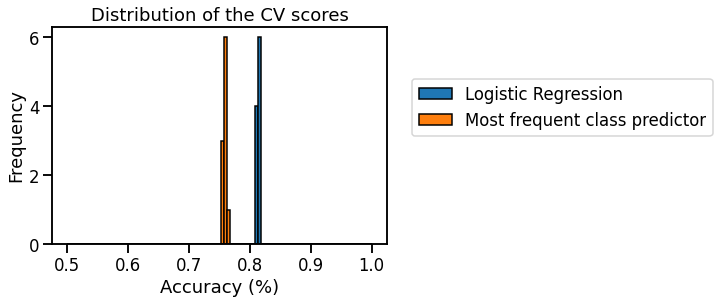

In [7]:
# solution
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(start=0.5, stop=1.0, num=100)
all_test_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the CV scores")

We observe that the two histograms are well separated. Therefore the dummy
classifier with the strategy `most_frequent` has a much lower accuracy
than the logistic regression classifier. We conclude that the logistic
regression model can successfully find predictive information in the input
features to improve upon the baseline.

Change the `strategy` of the dummy classifier to `"stratified"`, compute the
results. Similarly compute scores for `strategy="uniform"` and then the  plot
the distribution together with the other results.

Are those new baselines better than the previous one? Why is this the case?

Please refer to the scikit-learn documentation on
[sklearn.dummy.DummyClassifier](
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)
to find out about the meaning of the `"stratified"` and `"uniform"`
strategies.

In [8]:
# solution
stratified_dummy = DummyClassifier(strategy="stratified")
cv_results_stratified = cross_validate(
    stratified_dummy, data, target, cv=cv, n_jobs=2
)
test_score_dummy_stratified = pd.Series(
    cv_results_stratified["test_score"], name="Stratified class predictor"
)

In [9]:
uniform_dummy = DummyClassifier(strategy="uniform")
cv_results_uniform = cross_validate(
    uniform_dummy, data, target, cv=cv, n_jobs=2
)
test_score_dummy_uniform = pd.Series(
    cv_results_uniform["test_score"], name="Uniform class predictor"
)

In [10]:
all_test_scores = pd.concat(
    [
        test_score_logistic_regression,
        test_score_most_frequent,
        test_score_dummy_stratified,
        test_score_dummy_uniform,
    ],
    axis='columns',
)

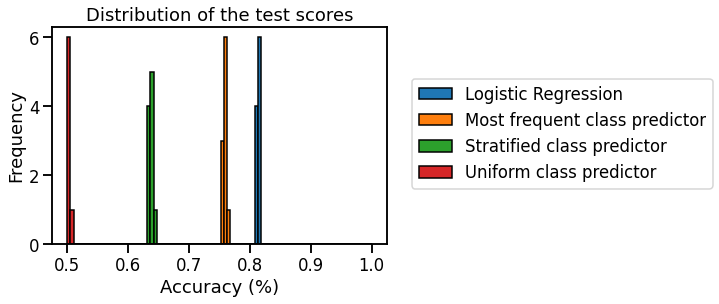

In [11]:
all_test_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Distribution of the test scores")

We see that using `strategy="stratified"`, the results are much worse than
with the `most_frequent` strategy. Since the classes are imbalanced,
predicting the most frequent involves that we will be right for the
proportion of this class (~75% of the samples). However, the `"stratified"`
strategy will randomly generate predictions by respecting the training
set's class distribution, resulting in some wrong predictions even for
the most frequent class, hence we obtain a lower accuracy.

This is even more so for the `strategy="uniform"`: this strategy assigns
class labels uniformly at random. Therefore, on a binary classification
problem, the cross-validation accuracy is 50% on average, which is the
weakest of the three dummy baselines.

Note: one could argue that the `"uniform"` or `strategy="stratified"`
strategies are both valid ways to define a "chance level" baseline accuracy
for this classification problem, because they make predictions "by chance".

Another way to define a chance level would be to use the
[sklearn.model_selection.permutation_test_score](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html)
utility of scikit-learn. Instead of using a dummy classifier, this function
compares the cross-validation accuracy of a model of interest to the
cross-validation accuracy of this same model but trained on randomly permuted
class labels. The `permutation_test_score` therefore defines a chance level
that depends on the choice of the class and hyper-parameters of the estimator
of interest. When training on such randomly permuted labels, many machine
learning estimators would end up approximately behaving much like the
`DummyClassifier(strategy="most_frequent")` by always predicting the majority
class, irrespective of the input features. As a result, this
`"most_frequent"` baseline is sometimes called the "chance level" for
imbalanced classification problems, even though its predictions are
completely deterministic and do not involve much "chance" anymore.

Defining the chance level using `permutation_test_score` is quite
computation-intensive because it requires fitting many non-dummy models on
random permutations of the data. Using dummy classifiers as baselines is
often enough for practical purposes. For imbalanced classification problems,
the `"most_frequent"` strategy is the strongest of the three baselines and
therefore the one we should use.